In [4]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import lucem_illud_2020

In [26]:
%matplotlib inline

In [27]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [28]:
gpu = torch.cuda.is_available()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [30]:
device

device(type='cpu')

In [31]:
df_sent = pd.read_json('iz_sent_label.json')

In [32]:
df_sent

,sent,year,type,label
0,"СООБЩЕНИЯ ИЗЗА РУБЕЖА ,ПОРТУГАЛИЯ Протс...",1985,communist,1
1,Со. корр.,1985,communist,1
2,"вИэвестмй, С изким осуждением открытого вмешат...",1985,communist,1
3,Газета выходит с марта годаСОВЕТОВ НАРОДНЫХ Д...,1985,communist,1
4,"Пиртш, Арс,ршру Абеле рие.",1985,communist,1
...,...,...,...,...
38053,Вот лишь некоторые из нихмощный Уобразный литр...,1997,democratic,0
38054,Форд Таурус устанавливает стандарты безопаснос...,1997,democratic,0
38055,"Познакомьтесь с ним, посетите нашего дилера.",1997,democratic,0
38056,"И Вы поймете, что автомобиль будущего это не п...",1997,democratic,0


In [34]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

SystemError: GPU device not found

In [35]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [36]:
import pandas as pd

In [37]:
df_sent = pd.read_json('iz_sent_label.json')

In [38]:
df_sent

,sent,year,type,label
0,"СООБЩЕНИЯ ИЗЗА РУБЕЖА ,ПОРТУГАЛИЯ Протс...",1985,communist,1
1,Со. корр.,1985,communist,1
2,"вИэвестмй, С изким осуждением открытого вмешат...",1985,communist,1
3,Газета выходит с марта годаСОВЕТОВ НАРОДНЫХ Д...,1985,communist,1
4,"Пиртш, Арс,ршру Абеле рие.",1985,communist,1
...,...,...,...,...
38053,Вот лишь некоторые из нихмощный Уобразный литр...,1997,democratic,0
38054,Форд Таурус устанавливает стандарты безопаснос...,1997,democratic,0
38055,"Познакомьтесь с ним, посетите нашего дилера.",1997,democratic,0
38056,"И Вы поймете, что автомобиль будущего это не п...",1997,democratic,0


In [39]:
sentences = df_sent.sent.values

In [40]:
sentences = ["[CLS] " + sent + " [SEP]" for sent in sentences]
labels = df_sent.label.values

In [41]:
tokenizer = BertTokenizer.from_pretrained('model_save', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print (tokenized_texts[0])

['[CLS]', 'сообщения', 'из', '##за', 'р', '##уб', '##ежа', ',', 'порт', '##уга', '##лия', 'про', '##тс', '##от', 'к', '##р', '##рч', '##те', 'о', '##ео', '##пр', '##лис', '##са', '##бон', '.', '[SEP]']


In [42]:
MAX_LEN = 512

In [43]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [44]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [45]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [46]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [47]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [48]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [49]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 32)           3825504   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 3,878,906
Trainable params: 3,878,906
Non-trainable params: 0
_________________________________________________________________


In [22]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
34252/34252 [==============================] - 1446s 42ms/step - loss: 0.6814 - accuracy: 0.5780
Epoch 2/10
34252/34252 [==============================] - 1427s 42ms/step - loss: 0.6811 - accuracy: 0.5786
Epoch 3/10
34252/34252 [==============================] - 1465s 43ms/step - loss: 0.6809 - accuracy: 0.5786
Epoch 4/10
34252/34252 [==============================] - 1468s 43ms/step - loss: 0.6809 - accuracy: 0.5786
Epoch 5/10
34252/34252 [==============================] - 1468s 43ms/step - loss: 0.6809 - accuracy: 0.5784
Epoch 6/10
34252/34252 [==============================] - 1450s 42ms/step - loss: 0.6808 - accuracy: 0.5786
Epoch 7/10
34252/34252 [==============================] - 1476s 43ms/step - loss: 0.6808 - accuracy: 0.5786
Epoch 8/10
34252/34252 [==============================] - 1446s 42ms/step - loss: 0.6808 - accuracy: 0.5786
Epoch 9/10
34252/34252 [==============================] - 1473s 43ms/step - loss: 0.6809 - accuracy: 0.5786
Epoch 10/10
34252/34252 [===

# BERT

In [50]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [51]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [52]:
model = BertForSequenceClassification.from_pretrained("model_save", num_labels=2)

In [53]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [54]:
df_sent['len'] = df_sent['sent'].str.len()

In [55]:
drop = df_sent[df_sent['len'] >= 513].index

In [56]:
df_sent.drop(drop, inplace = True)

In [57]:
df_sent

,sent,year,type,label,len
0,"СООБЩЕНИЯ ИЗЗА РУБЕЖА ,ПОРТУГАЛИЯ Протс...",1985,communist,1,70
1,Со. корр.,1985,communist,1,9
2,"вИэвестмй, С изким осуждением открытого вмешат...",1985,communist,1,212
3,Газета выходит с марта годаСОВЕТОВ НАРОДНЫХ Д...,1985,communist,1,70
4,"Пиртш, Арс,ршру Абеле рие.",1985,communist,1,26
...,...,...,...,...,...
38052,"Сегодня Таурус уже в России, и Вы сами можете ...",1997,democratic,0,75
38053,Вот лишь некоторые из нихмощный Уобразный литр...,1997,democratic,0,240
38054,Форд Таурус устанавливает стандарты безопаснос...,1997,democratic,0,91
38055,"Познакомьтесь с ним, посетите нашего дилера.",1997,democratic,0,44


In [58]:
MAX_LEN = 512

In [59]:
sentences = df_sent.sent.values
labels = df_sent.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [ ]:
# Positive samples: 15764 of 37644 (41.88%)

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

In [ ]:
matthews_set

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

In [ ]:
# MCC: 0.945
# ran this in colab

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

BERT works a lot better than LSTM. The accuracy of the LSTM remained at just under 60%, whereas BERT, looking at the MCC got very close to 1, indicating an almost perfect prediction.

# Embeddings, Context Words

In [5]:
from transformers import BertModel

In [6]:
tokenizer = BertTokenizer.from_pretrained('model_save')

In [63]:
text = "Скажи ка дядя, ведь не даром, Москва спаленная пожаром французам оттдана?"
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'с', '##ка', '##жи', 'ка', 'д', '##яд', '##я', ',', 'в', '##едь', 'не', 'дар', '##ом', ',', 'м', '##ос', '##ква', 'с', '##пал', '##енная', 'по', '##жар', '##ом', 'француз', '##ам', 'от', '##т', '##дана', '?', '[SEP]']


In [8]:
list(tokenizer.vocab.keys())[110000:110030]

['chamadas',
 'cuentan',
 'hispano',
 'kurioje',
 'verfasst',
 'максималној',
 'ಹೊಂದಿರುವ',
 '##eyin',
 '##isemmin',
 '##mètres',
 '##tə',
 '##ärit',
 '##اوح',
 '##জি',
 'DI',
 'accompanying',
 'aziende',
 '##ിക്കുകയും',
 '20일에',
 'Ceux',
 'solares',
 'връх',
 '##garos',
 '##бирался',
 '##ганга',
 'Peppers',
 'ninu',
 'кард',
 'позицию',
 'сулахай']

In [106]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все же союз республик развалился."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
союз         55,975
советских    57,940
со           10,956
##циал       72,459
##ист        24,142
##ечи        94,218
##ских       12,445
р               557
##ес         17,488
##пу         35,280
##бл         61,394
##ик         14,407
раз          17,257
##вали       16,882
##лся        17,204
в               543
1991         10,442
году         10,495
,               117
про          12,709
##жив        52,895
до           10,344
##ль         12,118
##ше         13,391
чем          18,658
пред         23,807
##ска        12,184
##зывали     87,903
страны       21,409
в               543
##ходив      46,012
##шие        23,352
в               543
союз         55,975
во           10,439
время        11,657
в               543
##тор        18,256
##ои         26,891
мир          29,345
##ово        20,007
##и          10,191
во           10,439
##ины        34,652
,               117
но           11,279
все          13,686
же           11,815
союз         55,975


# Segment ID

In [107]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [108]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [109]:
model_embedding = BertModel.from_pretrained('model_save')

model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [110]:
output = model_embedding(tokens_tensor)

In [111]:
len(output[0][0][0]), len(output[1][0])

(768, 768)

# understand output

In [112]:
word_embeddings, sentence_embedding = output

In [113]:
len(word_embeddings[0])

60

In [114]:
word_embeddings[0]

tensor([[-0.0193, -0.1291, -0.4511,  ...,  0.0292,  0.2991, -0.3247],
        [ 0.1620, -0.4918, -0.4288,  ...,  0.0871,  0.5391, -0.2483],
        [ 0.2348, -0.3958, -0.7399,  ..., -0.0778,  0.5489, -0.4390],
        ...,
        [-0.0351, -0.0777, -0.1743,  ...,  0.3205,  0.2540, -0.1551],
        [-0.2053, -0.0576, -0.4797,  ...,  0.0440,  0.2818, -0.1509],
        [-0.1434,  0.0705, -0.3703,  ...,  0.0605,  0.3457, -0.2940]],
       grad_fn=<SelectBackward>)

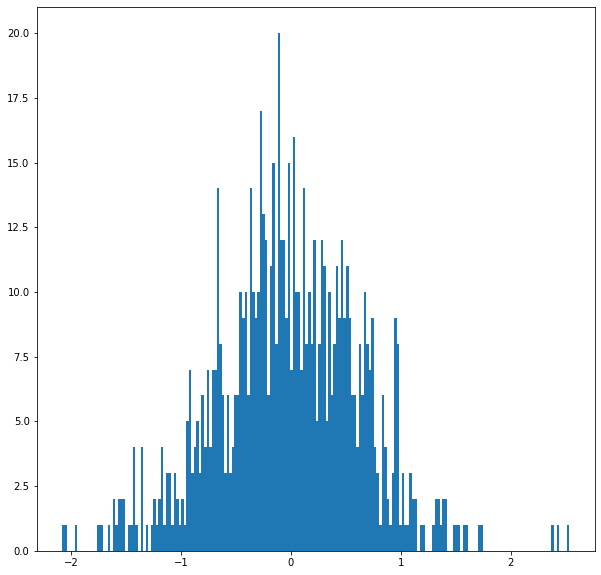

In [115]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

# word vectors

In [116]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [117]:
len(token_vecs)

60

# sentence vector

In [118]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [119]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [120]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

In [121]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 союз
2 советских
3 со
4 ##циал
5 ##ист
6 ##ечи
7 ##ских
8 р
9 ##ес
10 ##пу
11 ##бл
12 ##ик
13 раз
14 ##вали
15 ##лся
16 в
17 1991
18 году
19 ,
20 про
21 ##жив
22 до
23 ##ль
24 ##ше
25 чем
26 пред
27 ##ска
28 ##зывали
29 страны
30 в
31 ##ходив
32 ##шие
33 в
34 союз
35 во
36 время
37 в
38 ##тор
39 ##ои
40 мир
41 ##ово
42 ##и
43 во
44 ##ины
45 ,
46 но
47 все
48 же
49 союз
50 р
51 ##ес
52 ##пу
53 ##бл
54 ##ик
55 раз
56 ##вали
57 ##лся
58 .
59 [SEP]


In [122]:
print("Союз советских социалистечиских республик ", str(token_vecs[1][:5]))
print("союз во время второй мировой  ", str(token_vecs[34][:5]))
print("союз республик  ", str(token_vecs[49][:5]))

Союз советских социалистечиских республик  [ 0.16199194 -0.49180415 -0.42879653  0.19427085  0.8067099 ]
союз во время второй мировой   [-0.1552415  -0.27142113 -0.44934672 -0.078385    0.8664091 ]
союз республик   [ 0.15854509 -0.26785207 -0.507505    0.18087104  0.866567  ]


In [123]:
from scipy.spatial.distance import cosine

In [124]:
diff_union = 1 - cosine(token_vecs[1], token_vecs[34])

In [125]:
same_union = 1 - cosine(token_vecs[1], token_vecs[49])

In [126]:
print('Vector similarity for  *similar*  meanings:  %.2f' % same_union)
print('Vector similarity for *different* meanings:  %.2f' % diff_union)

Vector similarity for  *similar*  meanings:  0.99
Vector similarity for *different* meanings:  0.98


In [127]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

-0.03239362686872482

In [128]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)   
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [129]:
word_1 = word_vector(text, 1, model_embedding, tokenizer)
word_34 = word_vector(text, 34, model_embedding, tokenizer)
word_49 = word_vector(text, 49, model_embedding, tokenizer)

In [130]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings, sentence_embeddings = model(tokens_tensor)
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    return sentence_embedding

In [131]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

In [9]:
text = "Союз советских социалистечиских республик развалился в 1991 году, молодожены вступили в брачный союз, но все же союз республик развалился."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
союз         55,975
советских    57,940
со           10,956
##циал       72,459
##ист        24,142
##ечи        94,218
##ских       12,445
р               557
##ес         17,488
##пу         35,280
##бл         61,394
##ик         14,407
раз          17,257
##вали       16,882
##лся        17,204
в               543
1991         10,442
году         10,495
,               117
м               553
##оло        69,605
##до         17,961
##жены       45,467
вступил      57,101
##и          10,191
в               543
бр           109,300
##ач         47,990
##ны         11,307
##и          10,191
союз         55,975
,               117
но           11,279
все          13,686
же           11,815
союз         55,975
р               557
##ес         17,488
##пу         35,280
##бл         61,394
##ик         14,407
раз          17,257
##вали       16,882
##лся        17,204
.               119
[SEP]           102


In [14]:
segments_ids = [1] * len(tokenized_text)

In [15]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [17]:
model_embedding = BertModel.from_pretrained('model_save')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [18]:
output = model_embedding(tokens_tensor)

In [20]:
word_embeddings, sentence_embedding = output

In [21]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()

In [22]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [10]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 союз
2 советских
3 со
4 ##циал
5 ##ист
6 ##ечи
7 ##ских
8 р
9 ##ес
10 ##пу
11 ##бл
12 ##ик
13 раз
14 ##вали
15 ##лся
16 в
17 1991
18 году
19 ,
20 м
21 ##оло
22 ##до
23 ##жены
24 вступил
25 ##и
26 в
27 бр
28 ##ач
29 ##ны
30 ##и
31 союз
32 ,
33 но
34 все
35 же
36 союз
37 р
38 ##ес
39 ##пу
40 ##бл
41 ##ик
42 раз
43 ##вали
44 ##лся
45 .
46 [SEP]


In [23]:
print("Союз советских    ", str(token_vecs[1][:5]))
print("брачный союз  ", str(token_vecs[31][:5]))
print("союз республик  ", str(token_vecs[36][:5]))

Союз советских     [ 0.11943538 -0.8554804  -0.67102784  0.36061326  0.8835924 ]
брачный союз   [-0.10979369 -0.75671816 -0.599913    0.16908824  1.0096273 ]
союз республик   [ 0.13625544 -0.70203924 -0.69698596  0.29184407  0.8696393 ]


In [24]:
from scipy.spatial.distance import cosine

In [26]:
diff_union = 1 - cosine(token_vecs[1], token_vecs[31])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_union = 1 - cosine(token_vecs[1], token_vecs[36])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_union)
print('Vector similarity for *different* meanings:  %.2f' % diff_union)

Vector similarity for  *similar*  meanings:  0.98
Vector similarity for *different* meanings:  0.97


# transformers pipeline

In [28]:
from transformers import pipeline

In [133]:
nlp_sentiment = pipeline('sentiment-analysis')

In [134]:
nlp_sentiment("This BERT model is so good at classifiying sentiment, I love it.")

[{'label': 'POSITIVE', 'score': 0.9997735023498535}]

In [136]:
nlp_sentiment("Эта модель БЕРТ очень хорошо разбирается в настроение, я ее люблю.")

[{'label': 'POSITIVE', 'score': 0.6120728850364685}]

In [137]:
nlp_sentiment("I'm so sad that I have to spend this weekend just doing HW and readings.")

[{'label': 'NEGATIVE', 'score': 0.999719500541687}]

In [138]:
nlp_sentiment("Мне очень грустно что я должен все выходные провести над домашней работой и чтением.")

[{'label': 'NEGATIVE', 'score': 0.6776511073112488}]

In [139]:
# wow, that is actually really cool. It doesn't work as well with russian, but still captures the sentiment
# when translated almost literally

In [140]:
nlp_question = pipeline('question-answering')

In [141]:
nlp_question({
    
    
    'question': 'What is my favorite thing to do on weekends ?',
    'context': 'There is nothing I like more than analysing complex textual data all weekend '

})

{'score': 0.9860030258239121,
 'start': 34,
 'end': 64,
 'answer': 'analysing complex textual data'}

In [154]:
nlp_question({
    
    
    'question': 'Что я люблю делать по выходным?',
    'context': 'По выходным я люблю анализировать сложные текстовые данные'

})

{'score': 0.38139375340575654, 'start': 0, 'end': 11, 'answer': 'По выходным'}

In [146]:
# oof, not so good

In [155]:
nlp_question({
    
    
    'question': 'Что я люблю делать по выходным?',
    'context': 'Я люблю анализировать сложные текстовые данные по выходным'

})

{'score': 0.005732411163707485,
 'start': 47,
 'end': 57,
 'answer': 'по выходным'}

In [148]:
# yeah, not very good

In [149]:
nlp_feature = pipeline('feature-extraction')

In [150]:
vec = nlp_feature("Just sitting here exploring data all day long")

In [151]:
len(vec[0][0])

768

In [152]:
vec

[[[0.2807976305484772,
   0.06644466519355774,
   -0.1676395684480667,
   -0.1689605712890625,
   -0.22660820186138153,
   -0.14127111434936523,
   0.42102935910224915,
   -0.09199237823486328,
   -0.03190787509083748,
   -0.8537290692329407,
   -0.2683809697628021,
   0.08569976687431335,
   -0.13404327630996704,
   -0.034960370510816574,
   -0.5356060266494751,
   -0.029006678611040115,
   0.20110882818698883,
   0.08040329813957214,
   -0.08755538612604141,
   -0.08443030714988708,
   0.05363837629556656,
   -0.18426775932312012,
   0.5852558612823486,
   -0.1716005504131317,
   0.051204562187194824,
   0.12319854646921158,
   0.37301206588745117,
   0.16152000427246094,
   -0.17832477390766144,
   0.5117568373680115,
   -0.020196247845888138,
   0.19047752022743225,
   0.062378205358982086,
   0.057217083871364594,
   -0.36198365688323975,
   0.2284061163663864,
   -0.18473577499389648,
   -0.21770502626895905,
   -0.07018111646175385,
   -0.09863685071468353,
   -0.503352105617523

In [156]:
vec = nlp_feature("Сижу и весь день изучаю данные")

In [157]:
len(vec[0][0])

768

In [158]:
vec

[[[0.3649183213710785,
   -0.07871107757091522,
   -0.042051222175359726,
   -0.2034626305103302,
   -0.41293659806251526,
   -0.17903602123260498,
   0.26709863543510437,
   -0.08155889809131622,
   -0.10871081054210663,
   -1.2142983675003052,
   -0.5004412531852722,
   0.12474082410335541,
   -0.1004621684551239,
   -0.04409068077802658,
   -0.40494489669799805,
   0.14931221306324005,
   0.08835278451442719,
   0.13225679099559784,
   -0.16434836387634277,
   -0.16493481397628784,
   0.2663286626338959,
   -0.13785913586616516,
   0.6652872562408447,
   -0.18120893836021423,
   0.2874531149864197,
   -0.21904686093330383,
   0.3830167055130005,
   -0.06741100549697876,
   0.13990825414657593,
   0.4821166694164276,
   -0.1437099426984787,
   0.07760968059301376,
   0.05314428359270096,
   0.06852036714553833,
   -0.11953671276569366,
   0.38411086797714233,
   0.010342791676521301,
   -0.4711844325065613,
   -0.1615244448184967,
   -0.13067761063575745,
   -0.2751734256744385,
   -

In [29]:
mask_fill = pipeline("fill-mask")

In [30]:
print(mask_fill(f"HuggingFace is creating a {mask_fill.tokenizer.mask_token} that the community uses to solve NLP tasks."))

[{'sequence': '<s> HuggingFace is creating a tool that the community uses to solve NLP tasks.</s>', 'score': 0.157208651304245, 'token': 3944}, {'sequence': '<s> HuggingFace is creating a framework that the community uses to solve NLP tasks.</s>', 'score': 0.11565106362104416, 'token': 7208}, {'sequence': '<s> HuggingFace is creating a library that the community uses to solve NLP tasks.</s>', 'score': 0.059491824358701706, 'token': 5560}, {'sequence': '<s> HuggingFace is creating a database that the community uses to solve NLP tasks.</s>', 'score': 0.04147886484861374, 'token': 8503}, {'sequence': '<s> HuggingFace is creating a prototype that the community uses to solve NLP tasks.</s>', 'score': 0.025827670469880104, 'token': 17715}]


In [34]:
print(mask_fill(f"Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все же {mask_fill.tokenizer.mask_token} республик развалился."))

[{'sequence': '<s> Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все жем республик развалился.</s>', 'score': 0.7142915725708008, 'token': 46056}, {'sequence': '<s> Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все жед республик развалился.</s>', 'score': 0.17030398547649384, 'token': 37947}, {'sequence': '<s> Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все жет республик развалился.</s>', 'score': 0.04597889631986618, 'token': 35555}, {'sequence': '<s> Союз советских социалистечиских республик развалился в 1991 году, прожив дольше чем предсказывали страны входившие в союз во время второй мировой войны, но все жев республик развалился.</s>', 'score': 0.03486832

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

Previously we mostly compared word similarity, and did not really attempt to look at word meaning in context. That would have been pretty difficult to do. Even last week we worked under the assumption that words had only a single meaning when comparing food and occupation across gender and race, for example. Here, however, we are able to consider the way that the meaning of a word changes in context, and the way that a sentence changes its meaning based on all of the elemets combined within it. In a way this is simiar, because we are still pursuing the meaning of a word, and the social game that produces that meaning, but we are able to access that meaning in a different way, by examining context and changes in context, beyond the word itself. 

# Text Generation

In [159]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [160]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


In [173]:
sequence = "Ничего на свете лучше нету чем бродить"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Ничего на свете лучше нету чем бродить на пр


In [178]:
df_sent

,sent,year,type,label,len
0,"СООБЩЕНИЯ ИЗЗА РУБЕЖА ,ПОРТУГАЛИЯ Протс...",1985,communist,1,70
1,Со. корр.,1985,communist,1,9
2,"вИэвестмй, С изким осуждением открытого вмешат...",1985,communist,1,212
3,Газета выходит с марта годаСОВЕТОВ НАРОДНЫХ Д...,1985,communist,1,70
4,"Пиртш, Арс,ршру Абеле рие.",1985,communist,1,26
...,...,...,...,...,...
38052,"Сегодня Таурус уже в России, и Вы сами можете ...",1997,democratic,0,75
38053,Вот лишь некоторые из нихмощный Уобразный литр...,1997,democratic,0,240
38054,Форд Таурус устанавливает стандарты безопаснос...,1997,democratic,0,91
38055,"Познакомьтесь с ним, посетите нашего дилера.",1997,democratic,0,44


In [179]:
df_1985 = df_sent[df_sent['year'] == 1985]

In [180]:
df_1985

,sent,year,type,label,len
0,"СООБЩЕНИЯ ИЗЗА РУБЕЖА ,ПОРТУГАЛИЯ Протс...",1985,communist,1,70
1,Со. корр.,1985,communist,1,9
2,"вИэвестмй, С изким осуждением открытого вмешат...",1985,communist,1,212
3,Газета выходит с марта годаСОВЕТОВ НАРОДНЫХ Д...,1985,communist,1,70
4,"Пиртш, Арс,ршру Абеле рие.",1985,communist,1,26
...,...,...,...,...,...
16005,Однлнм не Дельнам Востоке пижльон мягтннп хчам...,1985,communist,1,177
16006,ДлительннаП период холодиой погоды ив Лель нем...,1985,communist,1,150
16007,МАШШМНАЯ ОЫМЕГМЯ.,1985,communist,1,17
16008,Ишгпв ПРЕЗИДИУМ!,1985,communist,1,16


In [181]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df_1985['sent'], test_size=0.2)

In [182]:
train_text.head()

12759    Задача этасложная, благород нтс, уникальная. н...
15618    В х годах СССР н США удавалось достигать лого ...
5661     В феврале с. г. аа складе американского оружия...
7487                         НО  В! Йнгском радмятпатрп...
164      Много добрых слов сказали о кандидате в депута...
Name: sent, dtype: object

In [183]:
test_text.head()

14417    Если привести их в действие, как отмечал Михаи...
2740     Каи иет производства без потребления, таи и по...
5290                                                     .
11180                               Так ведь оно законное!
7020        Требуется срочно убрать квартиру, вымыть окна.
Name: sent, dtype: object

In [184]:
train_text.to_frame().to_csv(r'train_text_1985', header=None, index=None, sep=' ', mode='a')

In [185]:
test_text.to_frame().to_csv(r'test_text_1985', header=None, index=None, sep=' ', mode='a')

In [186]:
df_1997 = df_sent[df_sent['year'] == 1997]

In [187]:
train_text, test_text = train_test_split(df_1997['sent'], test_size=0.2)

In [188]:
train_text.head()

31220                           Таковых примерно с дюжину.
24420    Между тем заявления участников рынка на получе...
35793    Большое внимание этому событию будет уделено с...
21734     Нам надо найти способы вхождения в мировое кино.
31274    Мы не будем надеяться или ждать их, мы будем и...
Name: sent, dtype: object

In [189]:
train_text.to_frame().to_csv(r'train_text_1997', header=None, index=None, sep=' ', mode='a')

In [190]:
test_text.to_frame().to_csv(r'test_text_1997', header=None, index=None, sep=' ', mode='a')

In [192]:
tokenizer_1985 = AutoTokenizer.from_pretrained("1985_tuned")
model_1985 = AutoModelWithLMHead.from_pretrained("1985_tuned")

In [196]:
sequence = "Победитель футбольного матча"

input = tokenizer_1985.encode(sequence, return_tensors="pt")
generated = model_1985.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1985.decode(generated.tolist()[0])
print(resulting_string)

Победитель футбольного матчального прошления �


In [197]:
sequence = "Победитель футбольного матча"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Победитель футбольного матча!!!!!!!!!!!!!!!!!!


In [198]:
df_complete = pd.read_json('izvestiia_sorted_lemmas.json')

In [200]:
df_1997_text = df_complete[df_complete['year'] == 1997]

In [202]:
train_text, test_text = train_test_split(df_1997_text['clean_text2'], test_size=0.2)

In [203]:
train_text.to_frame().to_csv(r'train_text_1997_text', header=None, index=None, sep=' ', mode='a')

In [204]:
test_text.to_frame().to_csv(r'test_text_1997_text', header=None, index=None, sep=' ', mode='a')

In [205]:
tokenizer_1997 = AutoTokenizer.from_pretrained("1997_tuned")
model_1997 = AutoModelWithLMHead.from_pretrained("1997_tuned")

In [206]:
sequence = "Победитель футбольного матча"

input = tokenizer_1997.encode(sequence, return_tensors="pt")
generated = model_1997.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997.decode(generated.tolist()[0])
print(resulting_string)

Победитель футбольного матчали предприятия в �


In [207]:
sequence = "Победитель футбольного матча"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Победитель футбольного матча!!!!!!!!!!!!!!!!!!


In [208]:
sequence = "Российская федерация предпринимяет"

input = tokenizer_1997.encode(sequence, return_tensors="pt")
generated = model_1997.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997.decode(generated.tolist()[0])
print(resulting_string)

Российская федерация предпринимяет принять пр


In [209]:
sequence = "Российская федерация банк"

input = tokenizer_1997.encode(sequence, return_tensors="pt")
generated = model_1997.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997.decode(generated.tolist()[0])
print(resulting_string)

Российская федерация банков предприятия в при


In [210]:
sequence = "Банки и предприятия"

input = tokenizer_1997.encode(sequence, return_tensors="pt")
generated = model_1997.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997.decode(generated.tolist()[0])
print(resulting_string)

Банки и предприятия в примерительство призводст


In [211]:
sequence = "Производство в россии"

input = tokenizer_1997.encode(sequence, return_tensors="pt")
generated = model_1997.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997.decode(generated.tolist()[0])
print(resulting_string)

Производство в россии предприятия в примеритель


In [214]:
tokenizer_1997_text = AutoTokenizer.from_pretrained("1997_tuned_text")
model_1997_text = AutoModelWithLMHead.from_pretrained("1997_tuned_text")

In [215]:
sequence = "Победитель футбольного матча"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Победитель футбольного матчали признать приз


In [216]:
sequence = "Российская федерация предпринимяет"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Российская федерация предпринимяет принять пр


In [217]:

sequence = "Российская федерация банк"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Российская федерация банков признать признат


In [218]:
sequence = "Банки и предприятия"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Банки и предприятия в привышленных привышленн


In [219]:
sequence = "Производство в россии"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Производство в россии при при при при при при пр


In [227]:
sequence = "процент"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

процентов признать признать признать признат


In [234]:
sequence = "Экономический рост в россии"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Экономический рост в россии в привышленных пр


In [240]:
sequence = "Промышленость в россии продолжает превышать"

input = tokenizer_1997_text.encode(sequence, return_tensors="pt")
generated = model_1997_text.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_1997_text.decode(generated.tolist()[0])
print(resulting_string)

Промышленость в россии продолжает превышать в �


## <span style="color:red">*Exercise 3*</span>
​
<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

So I have contructed multiple chat bots based on various samples of text from my data, and on various samplings of that text (1985 sentences vs 1997 sentences vs 1997 full text) and in all cases the chat bot doesnt work that well. arying input sentence legth and content also doesn't seem to result in meaningful results. In several cases the chat bot begins to grasp at something, but peters out. For example one sentence asks about the winners of a footbal game, and the chat bot responds that he winners of the game were acknowledged as (acknowledged as is new) but then doesnt finish the sentence. In another case I inputed something about economi production in russia, and the chat bot completed the sentence with companies and entreprenuers. This is quite similar to what the sentence was begining with, but again it left the sentence incomplete. 

The untrained model performed even worse, completing sentences about footbal games with just a bunch of exclamation points. 

In terms of the underlying social game, from the limited results that I got, we can tell that banks, Russia, companies, and entreprenuers are all tied together, as these are the words that the bot attempts to complete sentces about the others with. Certainly a striking contrast to 1985, where none of these words appear at all.

# Compare texts

In [228]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [243]:
model_embedding_1985 = RobertaModel.from_pretrained('1985_tuned')

In [245]:
tokenizer_1985 = RobertaTokenizer.from_pretrained('1985_tuned')

In [246]:
text = "Империя сша и нато продолжают агрессию." # Empure usa and nato continue agression
text1 = "Генеральный секретарь цк кпсс обещает построит социализм." # general secretary cc(central committee, common abrreviation) cpsu(sommunist party soviet union, common abbreviation) promises to build socialism
text2 = 'Банк и валютный рынок открывает акции с высокими процентами.' # bank and money market open stocks with high percentages
text3 = 'Граждане россии избирают на выборах кандидатов в депутаты.' # citizens russian elect on elections candidates for deputies (senators)

In [249]:
import seaborn as sns

In [247]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

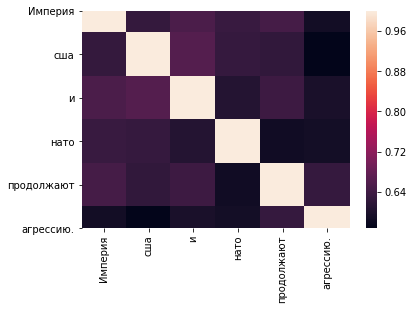

In [250]:
visualise_diffs(text, model_embedding_1985, tokenizer_1985)

In [251]:
model_embedding_1997 = RobertaModel.from_pretrained('1997_tuned')
tokenizer_1997 = RobertaTokenizer.from_pretrained('1997_tuned')

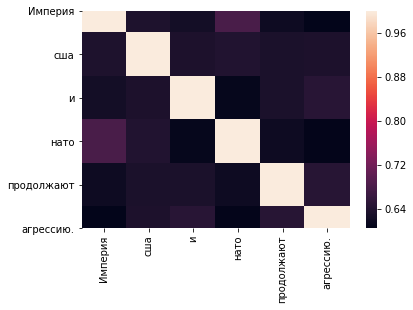

In [252]:
visualise_diffs(text, model_embedding_1997, tokenizer_1997)

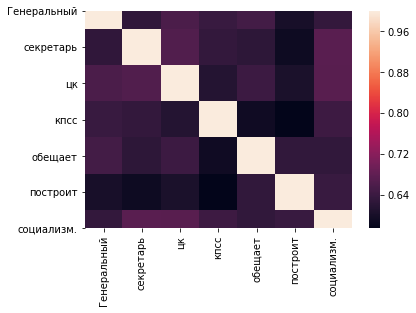

In [253]:
visualise_diffs(text1, model_embedding_1985, tokenizer_1985)

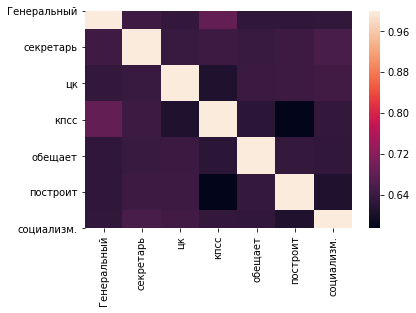

In [254]:
visualise_diffs(text1, model_embedding_1997, tokenizer_1997)

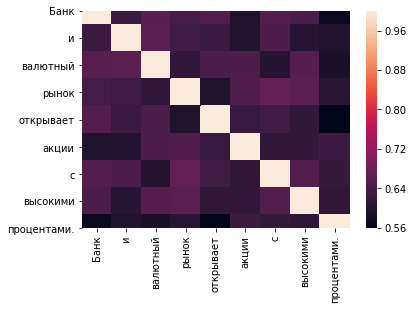

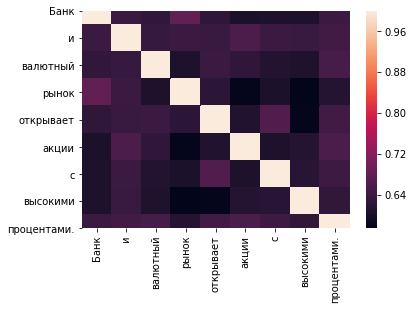

In [255]:
visualise_diffs(text2, model_embedding_1985, tokenizer_1985)
visualise_diffs(text2, model_embedding_1997, tokenizer_1997)

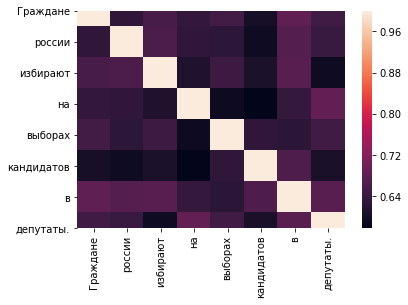

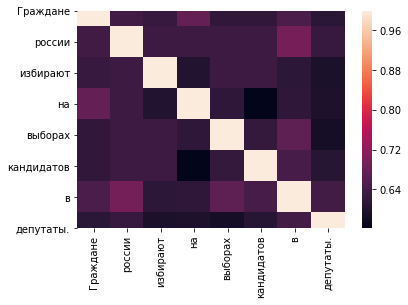

In [256]:
visualise_diffs(text3, model_embedding_1985, tokenizer_1985)
visualise_diffs(text3, model_embedding_1997, tokenizer_1997)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

Building off of the previous excercise I compared samples from my corpus from 1985 and 1997. Some distinct differences appear. 

In 1985 the word Empire is tied closely to NATO and the USA, whereas in 1997 there is a much weaker connection between them. However, the word agression is fairly weakly linked to USA and NATO in 1985, but becomes more strongly associated in 1997. This suggests an interesting dynamic between the Soviet and post-Soviet discourses, where the USA was seen as an enemy under communism, but not an agressor, and an agressor, but not an enemy under capitalism. Notably NATO is not connected with agression in 1997, suggesting that the anti-NATO rhetoric in Russia today originated later.

Also interesting are the stronger associations between all of the words in the sentence "The general secretary of the Communist Party of the Soviet Union promises to build socialism" in 1997, compared to 1985. In 1985 there is a fairly weak association between the communism(in general) and building, but that association rises sharply in 1997. I wonder if this could be the result of sharper criticisms of the party in 1997, where the connection between party and building was a lot stronger, but was bridged by a negation of that building (ie: the party didnt build anything). 

The sentence about banks and markets and percents is also interesting. In 1997 market and stocks are not as closely linked as they are in 1985, but market and bank are closely tied in 1997 in way that they are not in 1985. The introduction of banks and market capitalism seems to be reflected in this change. In general, also, the entire sentence seems to be more connected in 1985 than it is in 1997. Perhaps as a result of communist anti-capitalist rhetoric?

The final sentence about elections and senators is much more straight forward. Senators and elcetions are tied together in 1997, whereas there is no connection in 1985. In general Russia anc Citizens are connected much stronger to elections, candidates, electing, and senators in 1997 than they are in 1985. This is not suprising, given the transition to democracy that occured in 1992.